# Volcanic Eruption Impact on Climate from FLOR Ensemble: Chichon 1982
* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [2]:
%matplotlib notebook
!date

import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['hatch.color']='g'
import xarray as xr
from scipy.stats import ttest_1samp

from plotsetting import *
from geoplots import mapplot, xticksyear, xticksmonth
import geoxarray

Wed Apr 11 12:10:15 EDT 2018


In [3]:
from data_CTL1860 import open_ensemble as get_ctl
from data_chichon import open_data as get_volcano
volcano_name = 'Chichon'
year_volcano = 1982
ens = range(1,31)
nbname = 'volcano_impact_on_climate_chichon.ipynb'
new_names = {'grid_xt': 'lon', 'grid_yt': 'lat'}

land_mask = xr.open_dataset('/tigress/wenchang/MODEL_OUT/PIctl_CMIP6volc/POSTP/00010101.atmos_month.nc') \
    .land_mask.rename({'grid_xt': 'lon', 'grid_yt': 'lat'})

nino_ens = [ 7,  9, 12, 15, 17, 20, 22, 24, 27, 30]
nina_ens = [ 2,  6,  8, 13, 14, 18, 21, 25, 28, 29]
neut_ens = [1, 3, 4, 5, 10, 11, 16, 19, 23, 26]

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


## Net radiation (lw+sw) at TOA ``netrad_toa``

In [4]:
data_name = 'netrad_toa'

ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.netrad_toa.ctl.nc
Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.netrad_toa.nc


### Time series

In [5]:
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()
tsa = ts_volcano - ts_ctl
# NH and SH mean time series
tsas = dict(NH=(da_volcano - da_ctl).sel(lat=slice(0,90)).geo.fldmean(),
           SH=(da_volcano - da_ctl).sel(lat=slice(-90,0)).geo.fldmean())

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

<IPython.core.display.Javascript object>


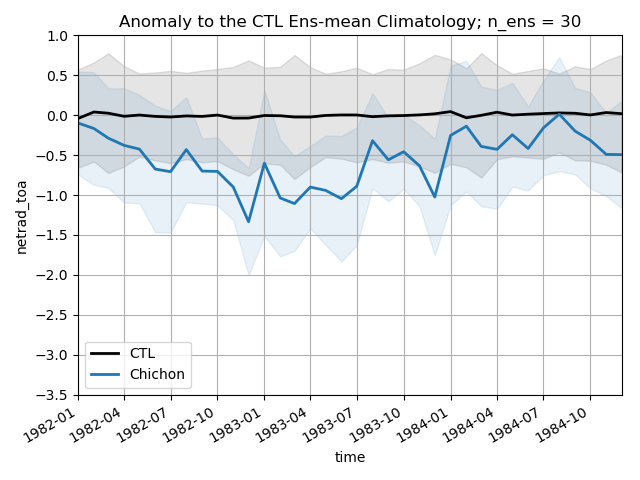

In [6]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(ts_ctl.isel(time=[0,-1]).time.to_index())
plt.ylim(-3.5, 1)
plt.tight_layout()

<IPython.core.display.Javascript object>


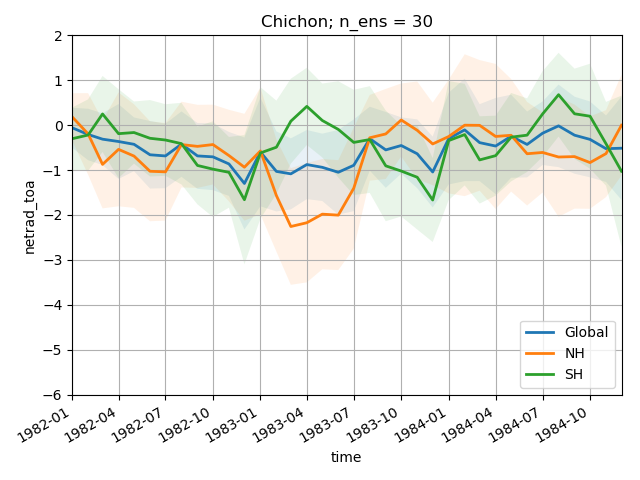

In [7]:
plt.fill_between(tsa.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    tsa.mean('en') - tsa.std('en'),
#     ts_ctl.max('en'),
    tsa.mean('en') + tsa.std('en'),
    alpha=0.1)
tsa.mean('en').plot(label='Global')

for key in ['NH', 'SH']:
    plt.fill_between(tsas[key].time.to_index().to_pydatetime(),
        tsas[key].mean('en') - tsas[key].std('en'),
    #     ts_ctl.max('en'),
        tsas[key].mean('en') + tsas[key].std('en'),
        alpha=0.1)
    tsas[key].mean('en').plot(label=key)

plt.ylabel(f'{data_name}')
plt.title(f'{volcano_name}; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsa.isel(time=[0,-1]).time.to_index())
plt.ylim(-6,2)
plt.legend(frameon=True, loc='lower right')
plt.tight_layout()

### Seasonal mean

In [7]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


<IPython.core.display.Javascript object>


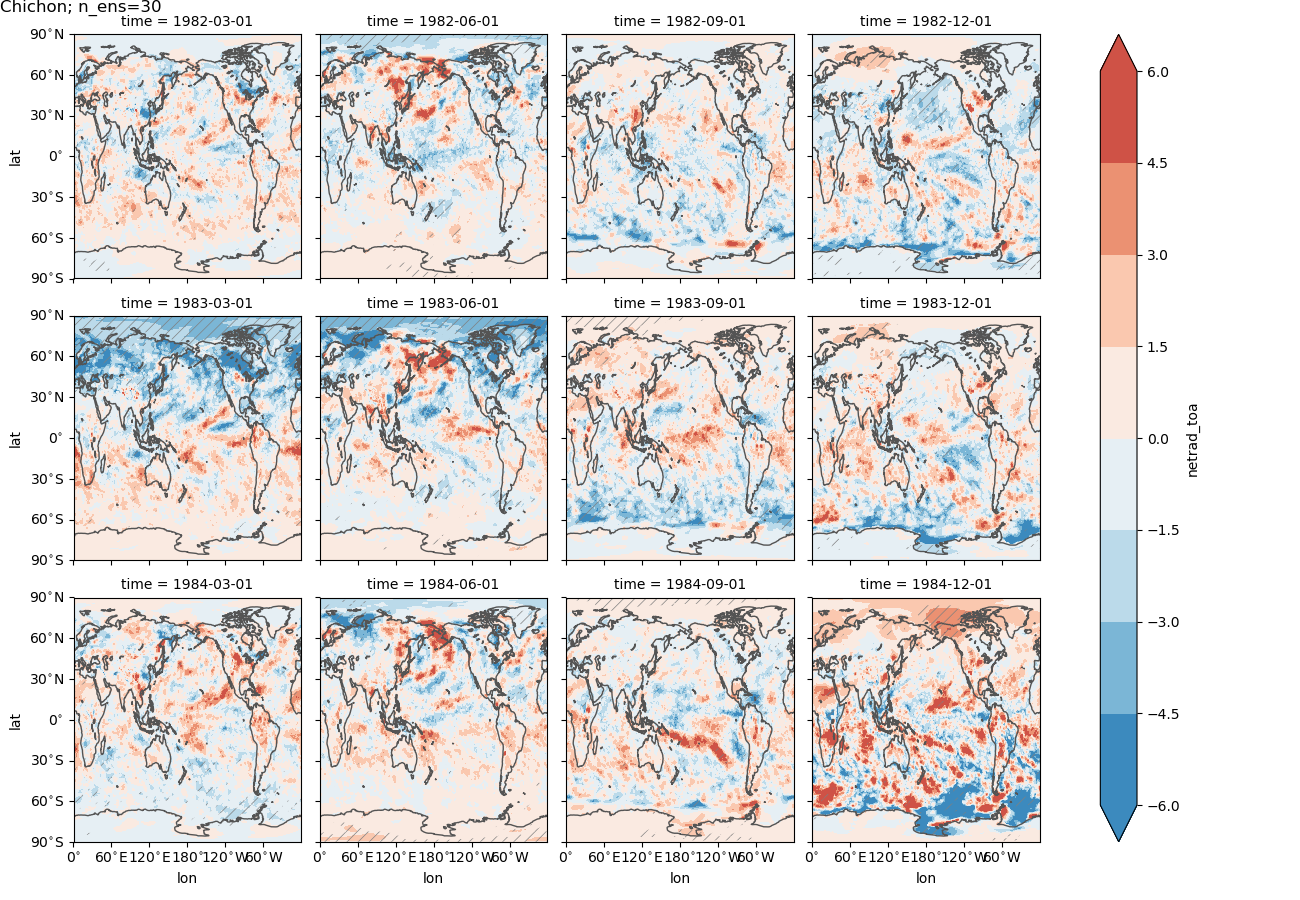

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; n_ens=30')

In [8]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

### Zonal mean

In [9]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

<IPython.core.display.Javascript object>


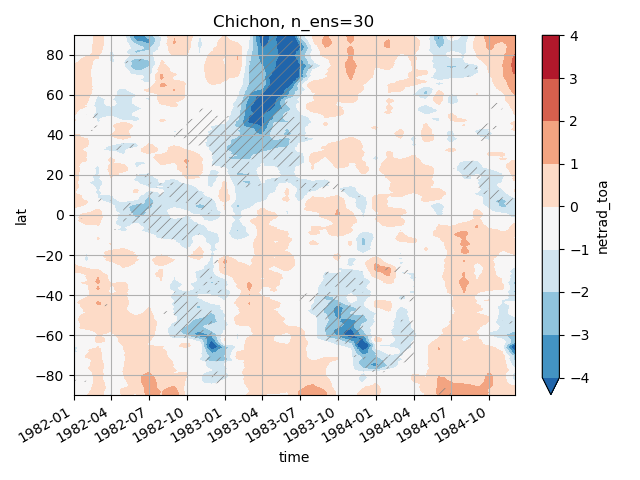

In [10]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0)
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

## Surface downward solar radiation ``swdn_sfc``

In [8]:
data_name = 'swdn_sfc'

ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.swdn_sfc.ctl.nc
Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.swdn_sfc.nc


### Time series

In [9]:
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()
tsa = ts_volcano - ts_ctl
# NH and SH mean time series
tsas = dict(NH=(da_volcano - da_ctl).sel(lat=slice(0,90)).geo.fldmean(),
           SH=(da_volcano - da_ctl).sel(lat=slice(-90,0)).geo.fldmean())

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

<IPython.core.display.Javascript object>


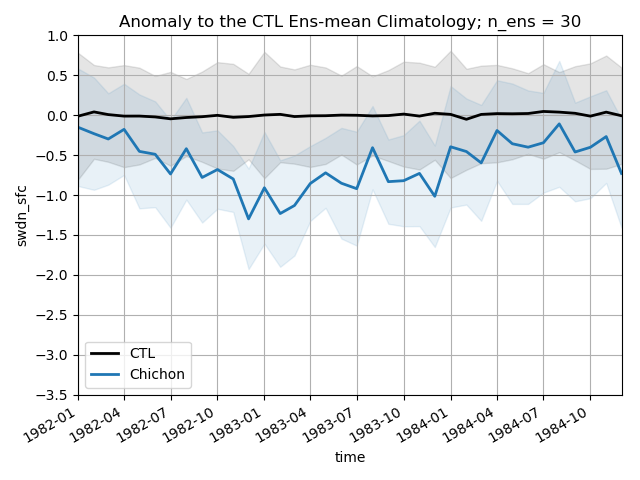

In [10]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(ts_ctl.isel(time=[0,-1]).time.to_index())
plt.ylim(-3.5,1)
plt.tight_layout()

<IPython.core.display.Javascript object>


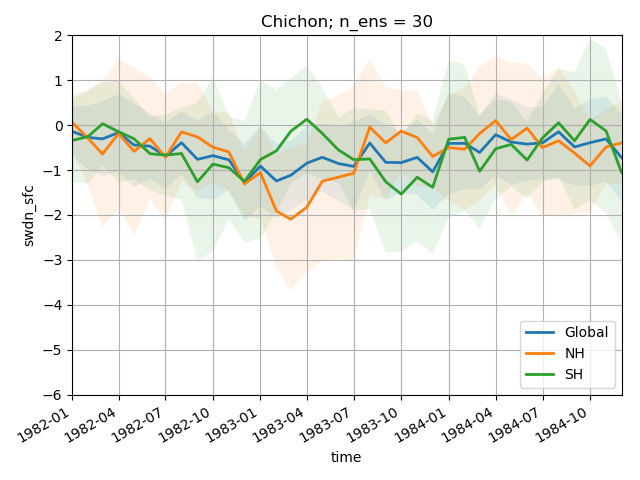

In [11]:
plt.fill_between(tsa.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    tsa.mean('en') - tsa.std('en'),
#     ts_ctl.max('en'),
    tsa.mean('en') + tsa.std('en'),
    alpha=0.1)
tsa.mean('en').plot(label='Global')

for key in ['NH', 'SH']:
    plt.fill_between(tsas[key].time.to_index().to_pydatetime(),
        tsas[key].mean('en') - tsas[key].std('en'),
    #     ts_ctl.max('en'),
        tsas[key].mean('en') + tsas[key].std('en'),
        alpha=0.1)
    tsas[key].mean('en').plot(label=key)

plt.ylabel(f'{data_name}')
plt.title(f'{volcano_name}; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsa.isel(time=[0,-1]).time.to_index())
plt.ylim(-6,2)
plt.legend(frameon=True, loc='lower right')
plt.tight_layout()

### Seasonal mean

In [8]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


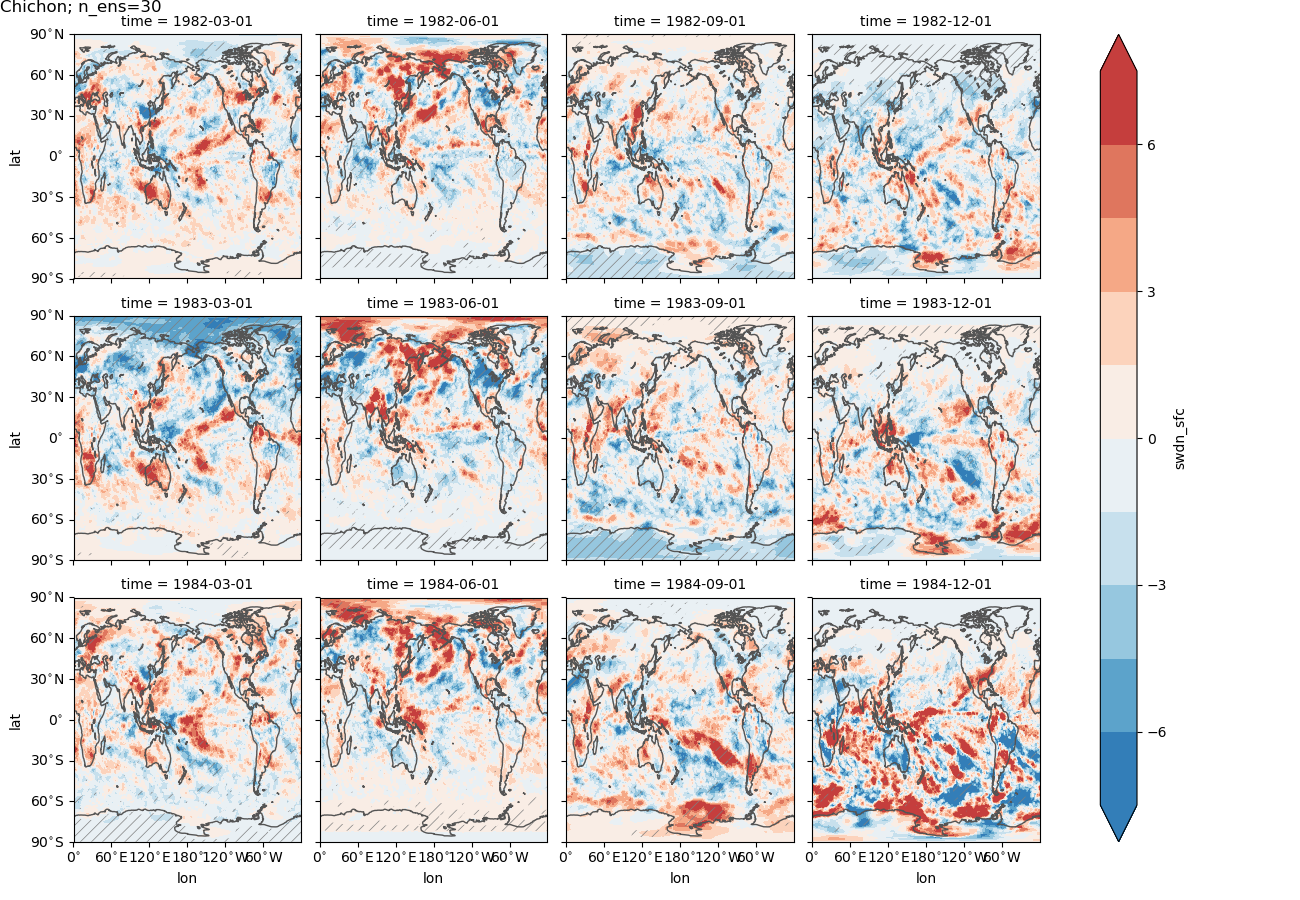

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [9]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

### Zonal mean

In [10]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


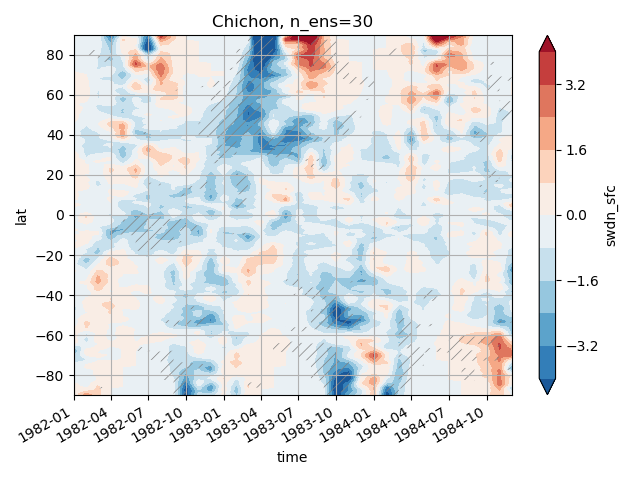

In [11]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0)
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

## Surface temperature ``t_surf``

In [52]:
data_name = 't_surf'

ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.t_surf.ctl.nc
Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.t_surf.nc


### Time series

In [13]:
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()
tsa = ts_volcano - ts_ctl
# NH and SH mean time series
tsas = dict(NH=(da_volcano - da_ctl).sel(lat=slice(0,90)).geo.fldmean(),
           SH=(da_volcano - da_ctl).sel(lat=slice(-90,0)).geo.fldmean())

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

<IPython.core.display.Javascript object>


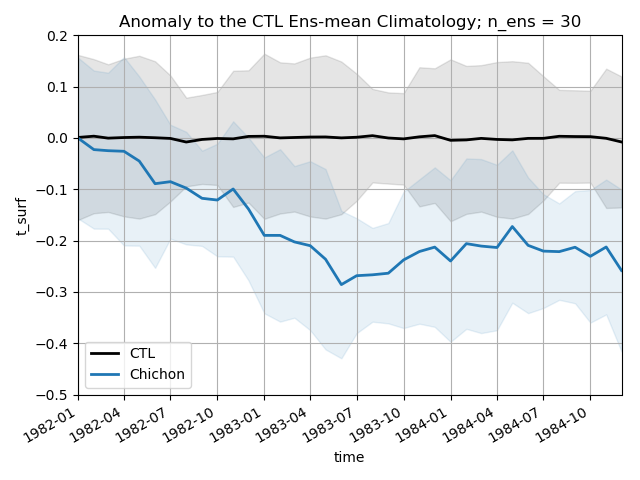

In [14]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(ts_ctl.isel(time=[0,-1]).time.to_index())
plt.ylim(-.5,.2)
plt.tight_layout()

<IPython.core.display.Javascript object>


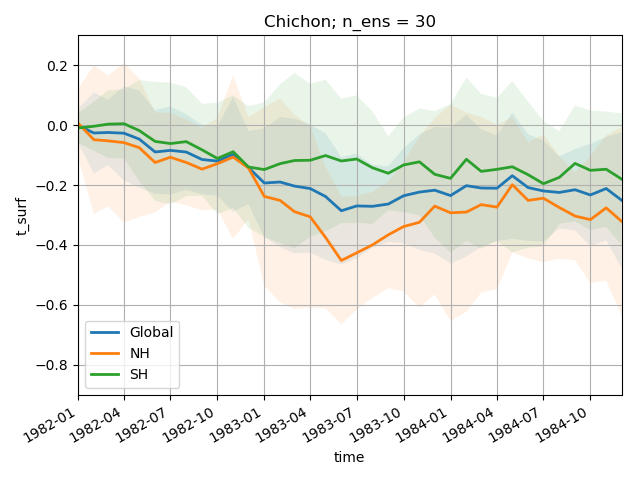

In [15]:
plt.fill_between(tsa.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    tsa.mean('en') - tsa.std('en'),
#     ts_ctl.max('en'),
    tsa.mean('en') + tsa.std('en'),
    alpha=0.1)
tsa.mean('en').plot(label='Global')

for key in ['NH', 'SH']:
    plt.fill_between(tsas[key].time.to_index().to_pydatetime(),
        tsas[key].mean('en') - tsas[key].std('en'),
    #     ts_ctl.max('en'),
        tsas[key].mean('en') + tsas[key].std('en'),
        alpha=0.1)
    tsas[key].mean('en').plot(label=key)

plt.ylabel(f'{data_name}')
plt.title(f'{volcano_name}; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(ts_ctl.isel(time=[0,-1]).time.to_index())
plt.ylim(-.9,.3)
plt.legend(frameon=True, loc='lower left')
plt.tight_layout()

### Seasonal mean

In [54]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

<IPython.core.display.Javascript object>


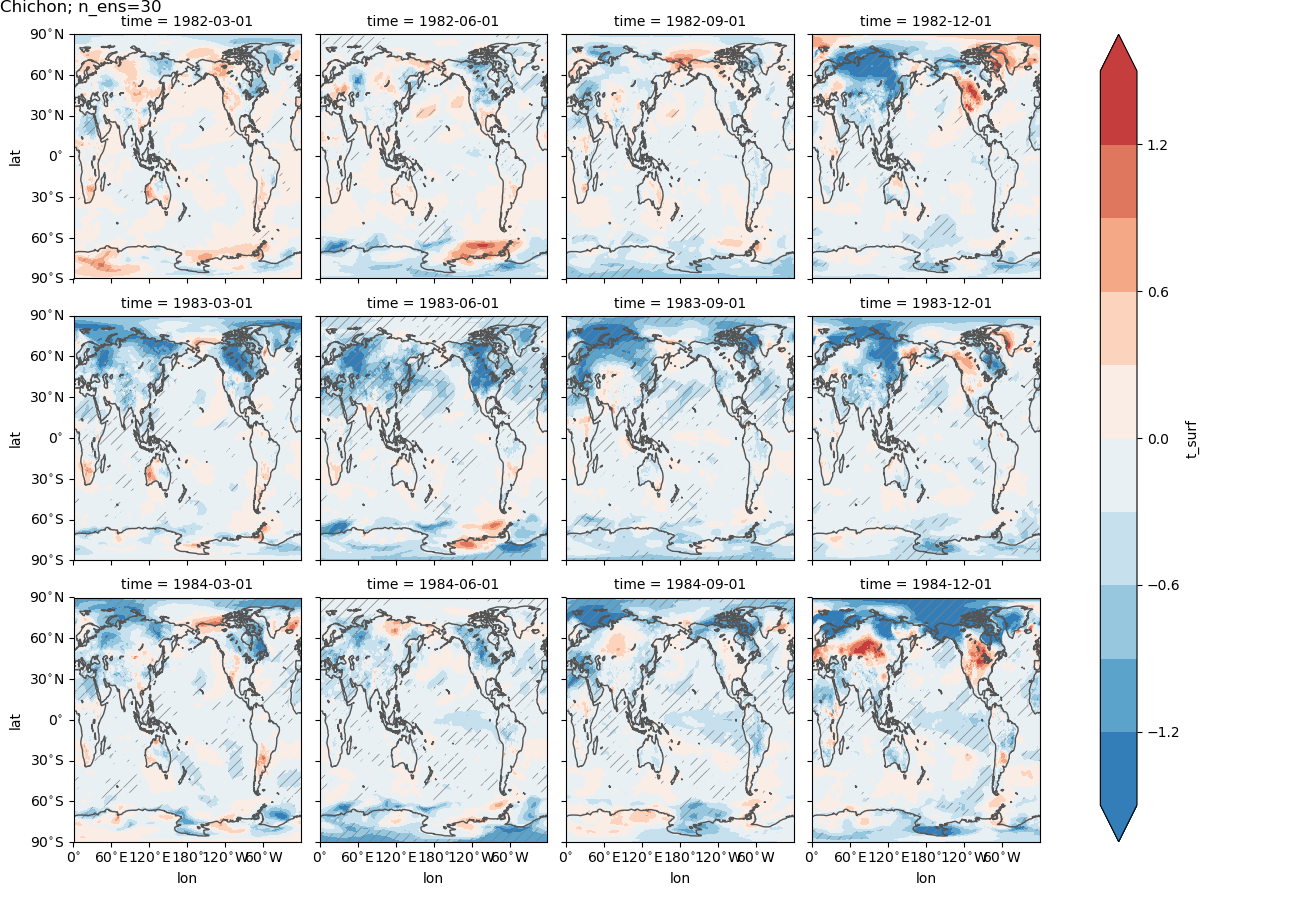

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [16]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

<IPython.core.display.Javascript object>


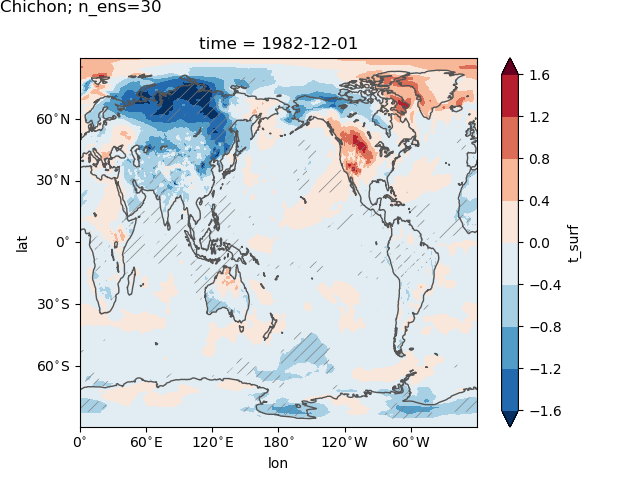

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; n_ens=30')

In [55]:
f = da.sel(time=f'{year_volcano}-12-01').plot.contourf(
    robust=True, levels=np.arange(-1.6,1.7,.4), center=0, extend='both')
mapplot(lw=0.2)
pp = pvalue.sel(time=f'{year_volcano}-12-01')
pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(
    colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left', va='top')

<IPython.core.display.Javascript object>


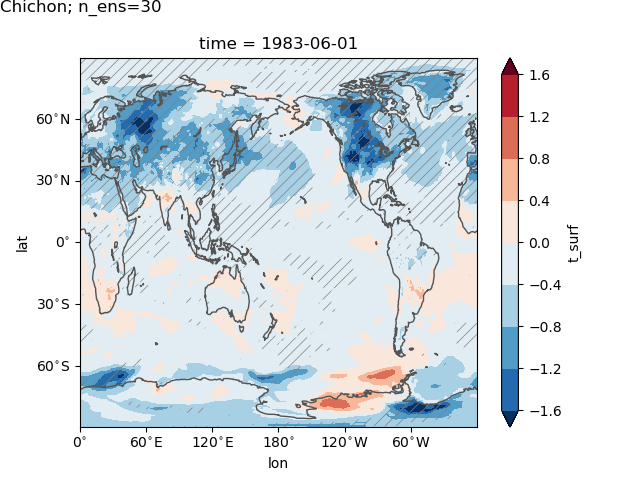

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; n_ens=30')

In [56]:
f = da.sel(time=f'{year_volcano+1}-06-01').plot.contourf(
    robust=True, levels=np.arange(-1.6,1.7,.4), center=0, extend='both')
mapplot(lw=0.2)
pp = pvalue.sel(time=f'{year_volcano+1}-06-01')
pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(
    colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left', va='top')

<IPython.core.display.Javascript object>


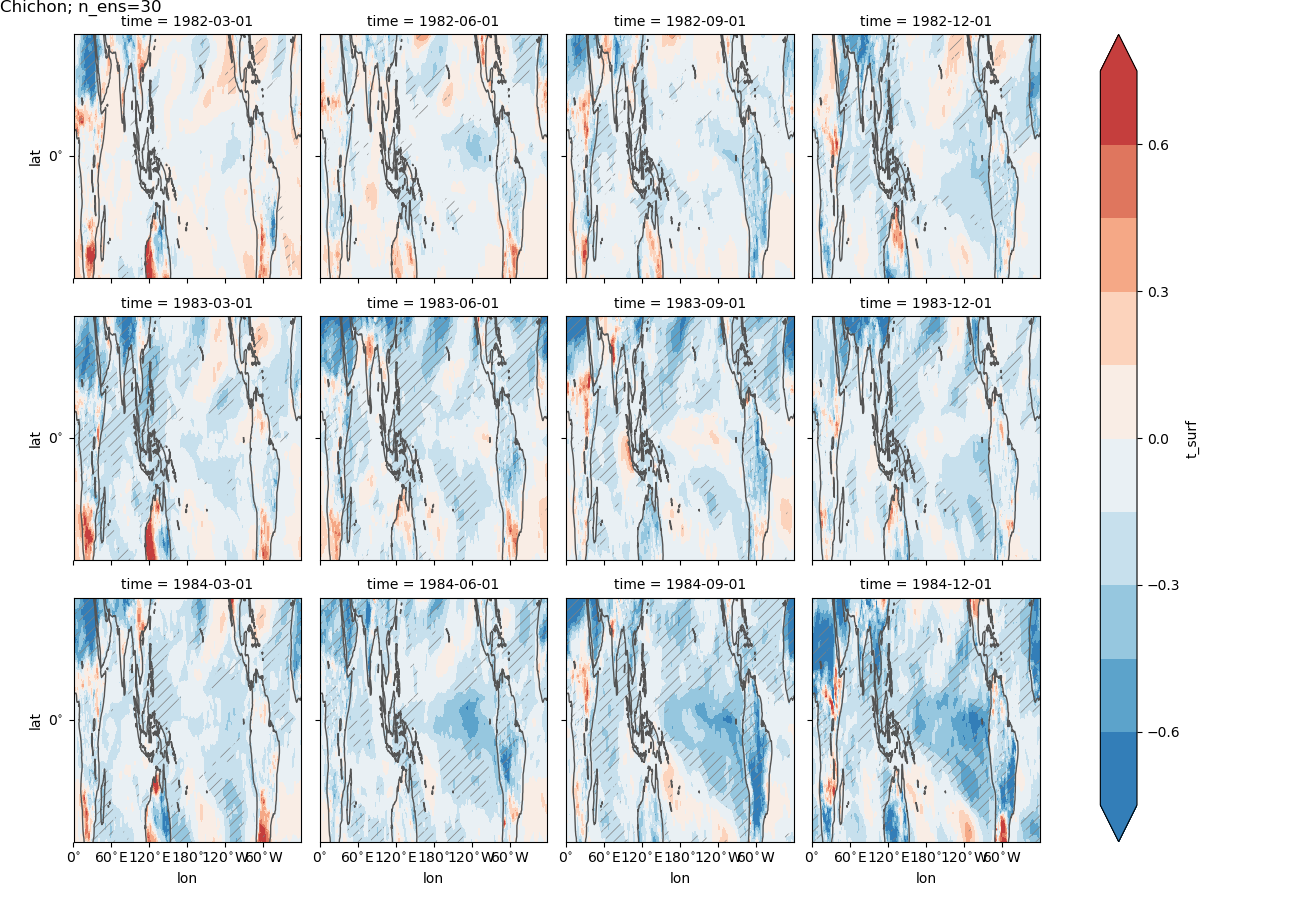

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [17]:
# tropics only
latrange = slice(-30,30)
f = da.sel(lat=latrange).plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).sel(lat=latrange).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

### Zonal mean

In [8]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


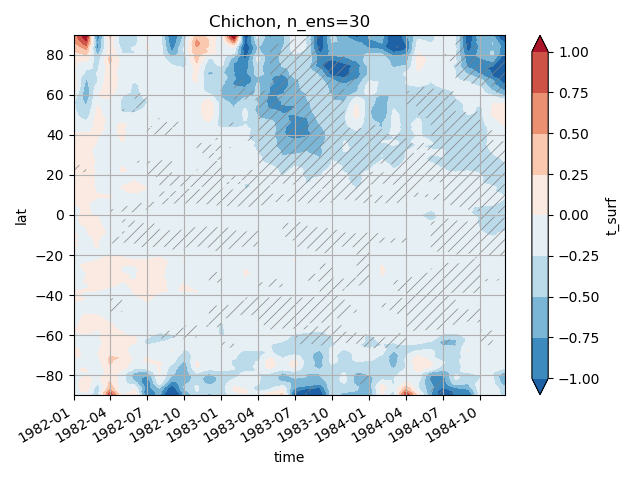

In [9]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0)
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

### ENSO

In [16]:
lons = dict(nino12=slice(360-90,360-80), 
    nino3=slice(360-150, 360-90),
    nino34=slice(360-170, 360-120),
    nino4=slice(160, 360-150))
lats = dict(nino12=slice(-10,0),
    nino3=slice(-5,5),
    nino34=slice(-5,5),
    nino4=slice(-5,5))
ts_ctl = da_ctl.sel(lon=lons['nino34'], lat=lats['nino34']).geo.fldmean()
ts_volc = da_volcano.sel(lon=lons['nino34'], lat=lats['nino34']).geo.fldmean()
ts_ctl_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
tsa_ctl = ts_ctl.groupby('time.month') - ts_ctl_clim
tsa_volc = ts_volc.groupby('time.month') - ts_ctl_clim

<IPython.core.display.Javascript object>


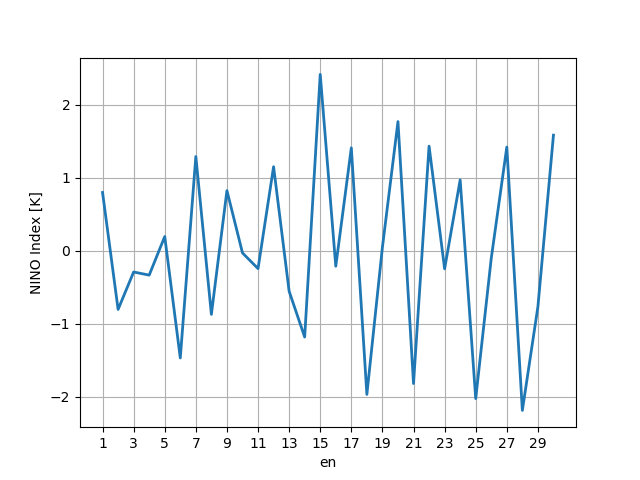

Nino ens: [ 7  9 12 15 17 20 22 24 27 30]
Nina ens: [ 2  6  8 13 14 18 21 25 28 29]
Neut ens: [1, 3, 4, 5, 10, 11, 16, 19, 23, 26]


In [17]:
# nino_i = tsa_volc.sel(time='1982-01').squeeze()
nino_i = tsa_ctl.sel(time=slice('1982-10', '1982-12')).mean('time')
ens_dict = dict()
ens_dict['nino'] = nino_i.en[nino_i > nino_i.quantile(0.67)].values
ens_dict['nina'] = nino_i.en[nino_i < nino_i.quantile(0.33)].values
ens_dict['neut'] = [en for en in range(1,31) if en not in ens_dict['nino'] and en not in ens_dict['nina']]
nino_i.plot()
# tsa_ctl.sel(time='1963-01').squeeze().plot()
plt.xticks(range(1,31,2))
plt.ylabel('NINO Index [K]')
plt.grid(True)
print('Nino ens:', ens_dict['nino'])
print('Nina ens:', ens_dict['nina'])
print('Neut ens:', ens_dict['neut'])

<IPython.core.display.Javascript object>


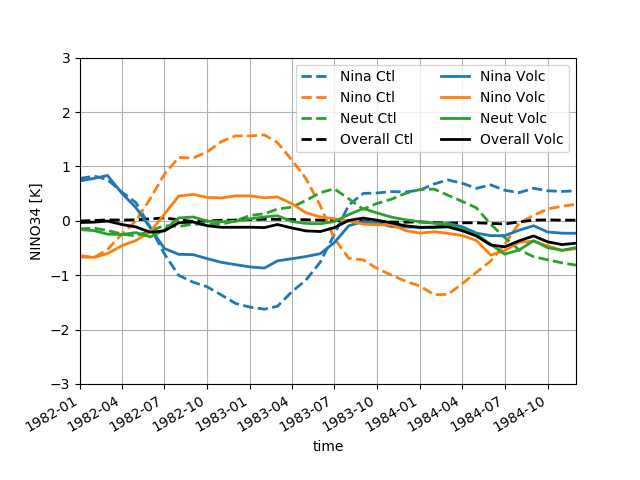

In [35]:
tsa_ctl.sel(en=ens_dict['nina']).mean('en').plot(label='Nina Ctl', color='C0', linestyle='--')
tsa_ctl.sel(en=ens_dict['nino']).mean('en').plot(label='Nino Ctl', color='C1', linestyle='--')
tsa_ctl.sel(en=ens_dict['neut']).mean('en').plot(label='Neut Ctl', color='C2', linestyle='--')
tsa_ctl.sel().mean('en').plot(label='Overall Ctl', color='k', linestyle='--')

tsa_volc.sel(en=ens_dict['nina']).mean('en').plot(label='Nina Volc', color='C0', linestyle='-')
tsa_volc.sel(en=ens_dict['nino']).mean('en').plot(label='Nino Volc', color='C1', linestyle='-')
tsa_volc.sel(en=ens_dict['neut']).mean('en').plot(label='Neut Volc', color='C2', linestyle='-')
tsa_volc.sel().mean('en').plot(label='Overall Volc', color='k', linestyle='-')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsa_ctl.time.isel(time=[0,-1]).to_index())
plt.ylim(-3,3)
plt.ylabel('NINO34 [K]')
plt.legend(frameon=True, loc='upper right', ncol=2)

<IPython.core.display.Javascript object>


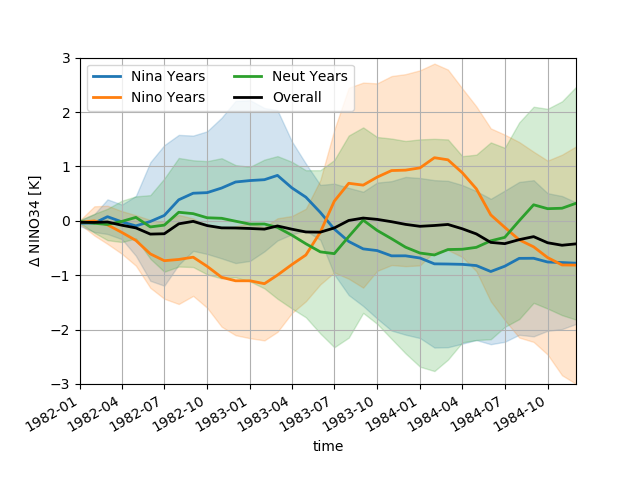

Text(0,0.5,'$\\Delta$ NINO34 [K]')

In [31]:
tsaa = (tsa_volc - tsa_ctl).sel(en=ens_dict['nina'])
plt.fill_between(tsaa.time.to_index().to_pydatetime(),
    tsaa.mean('en') - tsaa.std('en'),
    tsaa.mean('en') + tsaa.std('en'),
    alpha=0.2, color='C0')
tsaa.mean('en').plot(label='Nina Years', color='C0')

tsaa = (tsa_volc - tsa_ctl).sel(en=ens_dict['nino'])
plt.fill_between(tsaa.time.to_index().to_pydatetime(),
    tsaa.mean('en') - tsaa.std('en'),
    tsaa.mean('en') + tsaa.std('en'),
    alpha=0.2, color='C1')
tsaa.mean('en').plot(label='Nino Years', color='C1')

tsaa = (tsa_volc - tsa_ctl).sel(en=ens_dict['neut'])
plt.fill_between(tsaa.time.to_index().to_pydatetime(),
    tsaa.mean('en') - tsaa.std('en'),
    tsaa.mean('en') + tsaa.std('en'),
    alpha=0.2, color='C2')
tsaa.mean('en').plot(label='Neut Years', color='C2')

tsaa = (tsa_volc - tsa_ctl)
tsaa.mean('en').plot(label='Overall', color='k')


plt.legend(frameon=True, loc='upper left', ncol=2)
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsaa.time.isel(time=[0,-1]).to_index())
plt.ylim(-3,3)
plt.ylabel('$\Delta$ NINO34 [K]')

## Precipitation ``precip``

In [4]:
data_name = 'precip'
scale_factor = 3600*24

ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

da_ctl = da_ctl * scale_factor
da_volcano = da_volcano * scale_factor

Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.precip.ctl.nc
Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.precip.nc


### Time series

In [37]:
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()
tsa = ts_volcano - ts_ctl
# NH and SH mean time series
tsas = dict(NH=(da_volcano - da_ctl).sel(lat=slice(0,90)).geo.fldmean(),
           SH=(da_volcano - da_ctl).sel(lat=slice(-90,0)).geo.fldmean())

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

<IPython.core.display.Javascript object>


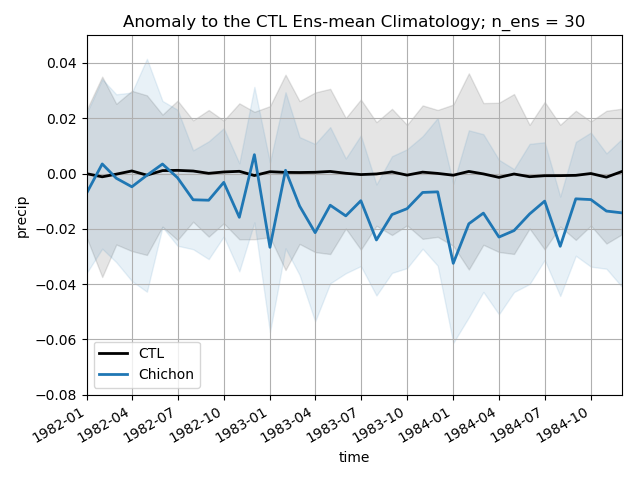

In [38]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(ts_ctl.isel(time=[0,-1]).time.to_index())
plt.ylim(-.08,.05)
plt.tight_layout()

<IPython.core.display.Javascript object>


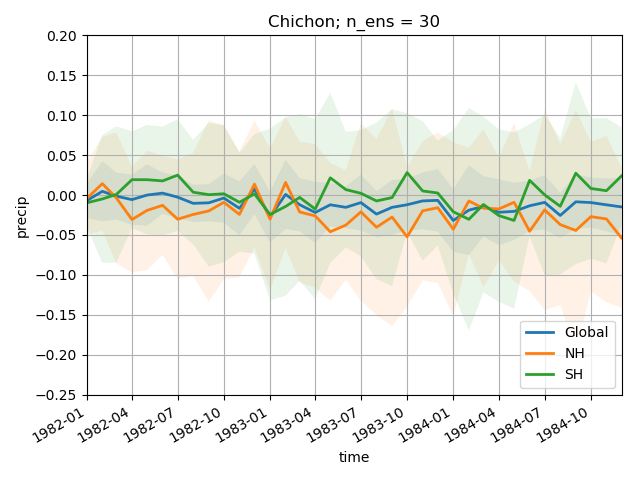

In [39]:
plt.fill_between(tsa.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    tsa.mean('en') - tsa.std('en'),
#     ts_ctl.max('en'),
    tsa.mean('en') + tsa.std('en'),
    alpha=0.1)
tsa.mean('en').plot(label='Global')

for key in ['NH', 'SH']:
    plt.fill_between(tsas[key].time.to_index().to_pydatetime(),
        tsas[key].mean('en') - tsas[key].std('en'),
    #     ts_ctl.max('en'),
        tsas[key].mean('en') + tsas[key].std('en'),
        alpha=0.1)
    tsas[key].mean('en').plot(label=key)

plt.ylabel(f'{data_name}')
plt.title(f'{volcano_name}; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsa.isel(time=[0,-1]).time.to_index())
plt.ylim(-.25,.20)
plt.legend(frameon=True, loc='lower right')
plt.tight_layout()

### Seasonal mean

In [17]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

<IPython.core.display.Javascript object>


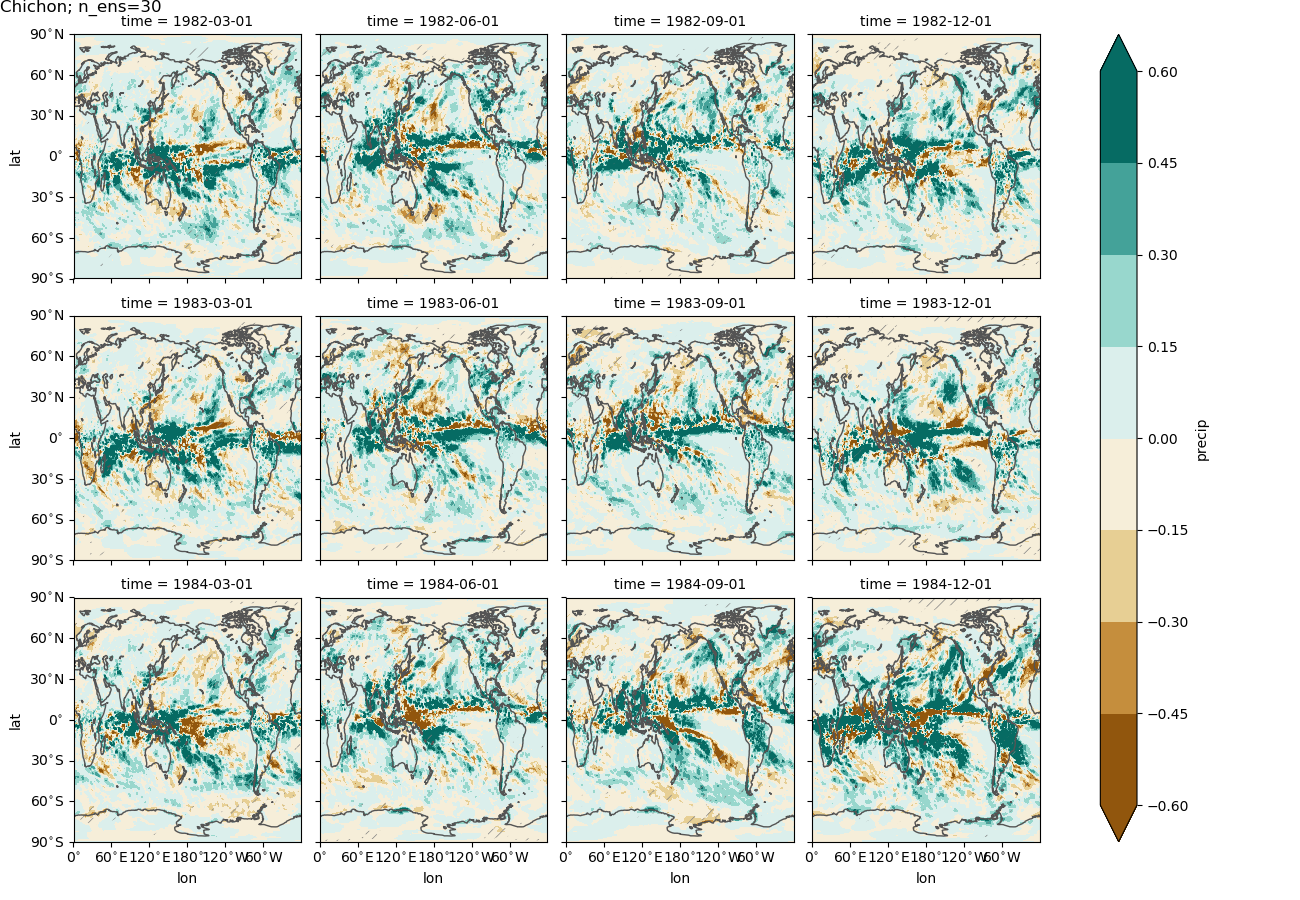

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; n_ens=30')

In [18]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both', cmap='BrBG')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

<IPython.core.display.Javascript object>


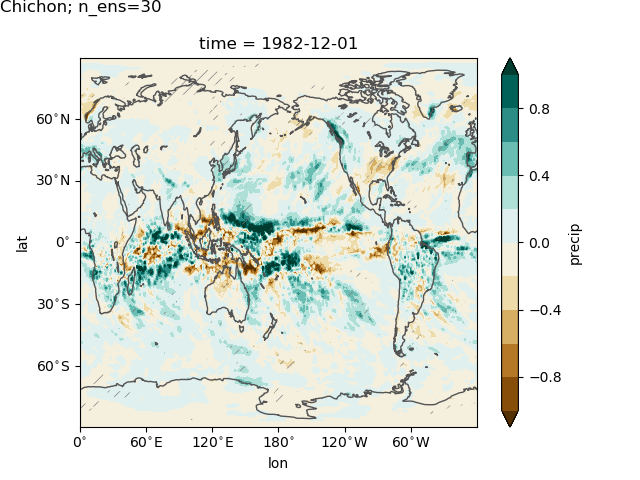

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; n_ens=30')

In [19]:
f = da.sel(time=f'{year_volcano}-12-01').plot.contourf(
    robust=True, levels=np.arange(-1,1.1,.2), center=0, extend='both', cmap='BrBG')
mapplot(lw=0.2)
pp = pvalue.sel(time=f'{year_volcano}-12-01')
pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(
    colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left', va='top')

<IPython.core.display.Javascript object>


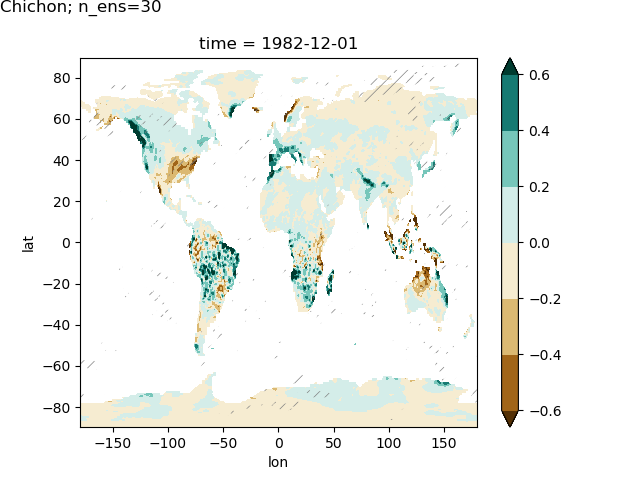

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; n_ens=30')

In [20]:
lon = da.lon.roll(lon=int(576/2)).values
lon[lon>180] = lon[lon>180] - 360
f = da.sel(time=f'{year_volcano}-12-01').where(land_mask>0.5).roll(lon=int(576/2)).assign_coords(lon=lon).plot.contourf(
    robust=True, 
#     levels=np.arange(-1,1.1,.2), 
    levels=None,
    center=0, extend='both', cmap='BrBG')
# mapplot(lw=0.2)
pp = pvalue.sel(time=f'{year_volcano}-12-01')
pp.where(pp<0.05).pipe(lambda x:x*0).roll(lon=int(576/2)).assign_coords(lon=lon).plot.contourf(
    colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left', va='top')

<IPython.core.display.Javascript object>


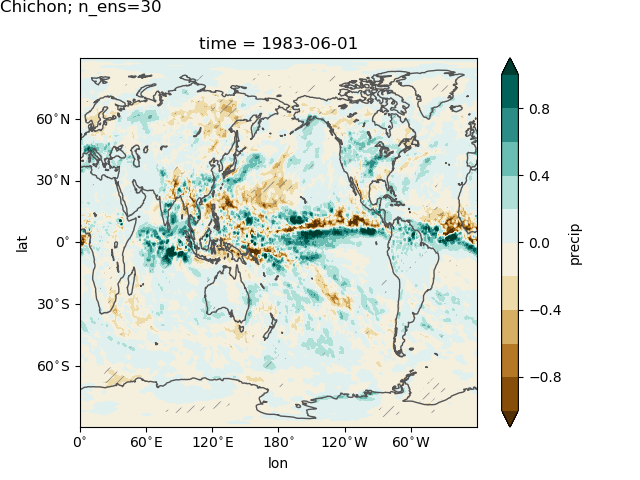

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; n_ens=30')

In [51]:
f = da.sel(time=f'{year_volcano+1}-06-01').plot.contourf(
    robust=True, levels=np.arange(-1,1.1,.2), center=0, extend='both', cmap='BrBG')
mapplot(lw=0.2)
pp = pvalue.sel(time=f'{year_volcano+1}-06-01')
pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(
    colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left', va='top')

<IPython.core.display.Javascript object>


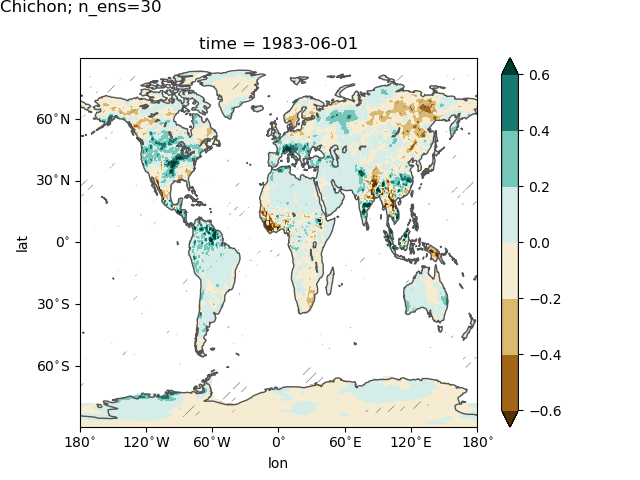

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; n_ens=30')

In [21]:
lon = da.lon.roll(lon=int(576/2)).values
lon[lon>180] = lon[lon>180] - 360
f = da.sel(time=f'{year_volcano+1}-06-01').where(land_mask>.5) \
    .roll(lon=int(576/2)).assign_coords(lon=lon).plot.contourf(
    robust=True, 
#     levels=np.arange(-1,1.1,.2), 
    levels=None,
    center=0, extend='both', cmap='BrBG')
mapplot(lw=0.2)
pp = pvalue.sel(time=f'{year_volcano+1}-06-01')
pp.where(pp<0.05).pipe(lambda x:x*0).roll(lon=int(576/2)).assign_coords(lon=lon).plot.contourf(
    colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left', va='top')

### Seasonal mean: Nino ens

In [5]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.sel(en=nino_ens) ##################
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

<IPython.core.display.Javascript object>


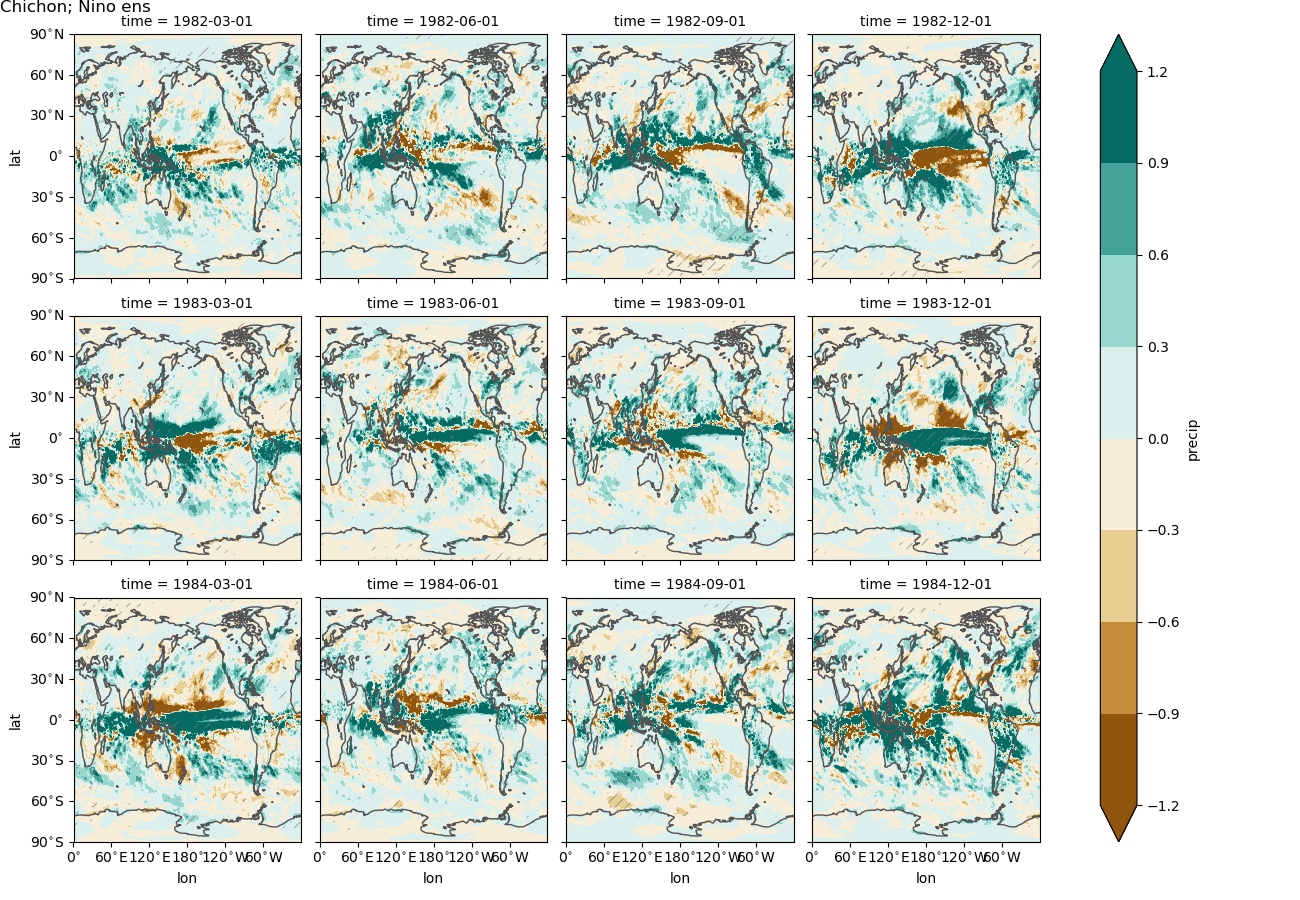

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; Nino ens')

In [11]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both', cmap='BrBG')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; Nino ens', x=0, y=1, ha='left')

<IPython.core.display.Javascript object>


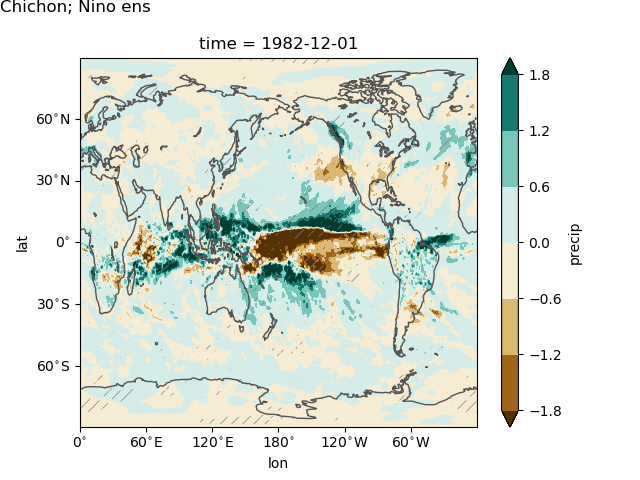

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; Nino ens')

In [12]:
f = da.sel(time=f'{year_volcano}-12-01').plot.contourf(
    robust=True, 
#     levels=np.arange(-1,1.1,.2),
    levels=None,
    center=0, extend='both', cmap='BrBG')
mapplot(lw=0.2)
pp = pvalue.sel(time=f'{year_volcano}-12-01')
pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(
    colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; Nino ens', x=0, y=1, ha='left', va='top')

<IPython.core.display.Javascript object>


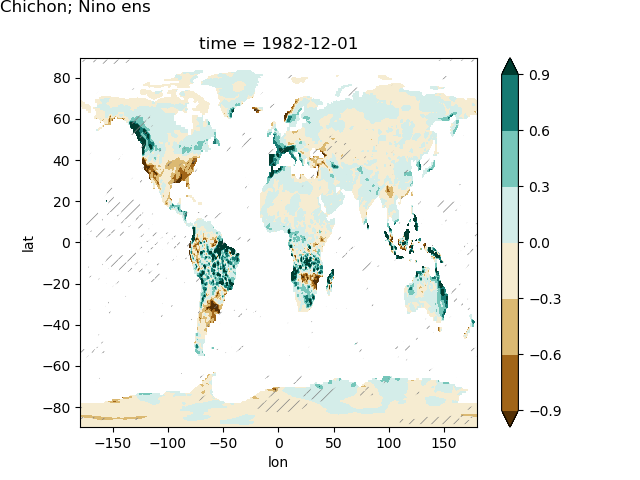

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; Nino ens')

In [13]:
lon = da.lon.roll(lon=int(576/2)).values
lon[lon>180] = lon[lon>180] - 360
f = da.sel(time=f'{year_volcano}-12-01').where(land_mask>0.5).roll(lon=int(576/2)).assign_coords(lon=lon).plot.contourf(
    robust=True, 
#     levels=np.arange(-1,1.1,.2), 
    levels=None,
    center=0, extend='both', cmap='BrBG')
# mapplot(lw=0.2)
pp = pvalue.sel(time=f'{year_volcano}-12-01')
pp.where(pp<0.05).pipe(lambda x:x*0).roll(lon=int(576/2)).assign_coords(lon=lon).plot.contourf(
    colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; Nino ens', x=0, y=1, ha='left', va='top')

<IPython.core.display.Javascript object>


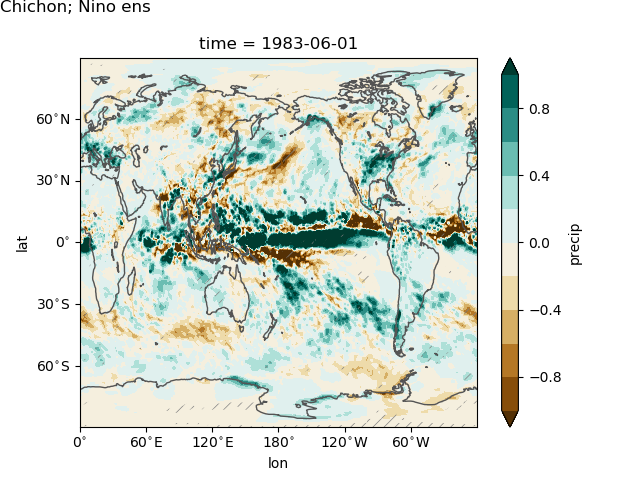

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; Nino ens')

In [14]:
f = da.sel(time=f'{year_volcano+1}-06-01').plot.contourf(
    robust=True, levels=np.arange(-1,1.1,.2), center=0, extend='both', cmap='BrBG')
mapplot(lw=0.2)
pp = pvalue.sel(time=f'{year_volcano+1}-06-01')
pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(
    colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; Nino ens', x=0, y=1, ha='left', va='top')

<IPython.core.display.Javascript object>


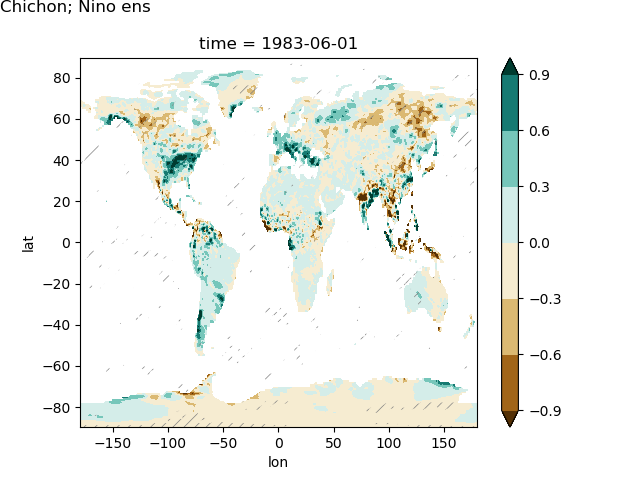

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Chichon; Nino ens')

In [16]:
lon = da.lon.roll(lon=int(576/2)).values
lon[lon>180] = lon[lon>180] - 360
f = da.sel(time=f'{year_volcano+1}-06-01').where(land_mask>.5).roll(lon=int(576/2)).assign_coords(lon=lon).plot.contourf(
    robust=True, 
#     levels=np.arange(-1,1.1,.2), 
    levels=None,
    center=0, extend='both', cmap='BrBG')
# mapplot(lw=0.2)
pp = pvalue.sel(time=f'{year_volcano+1}-06-01')
pp.where(pp<0.05).pipe(lambda x:x*0).roll(lon=int(576/2)).assign_coords(lon=lon).plot.contourf(
    colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; Nino ens', x=0, y=1, ha='left', va='top')

### Zonal mean

In [28]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

<IPython.core.display.Javascript object>


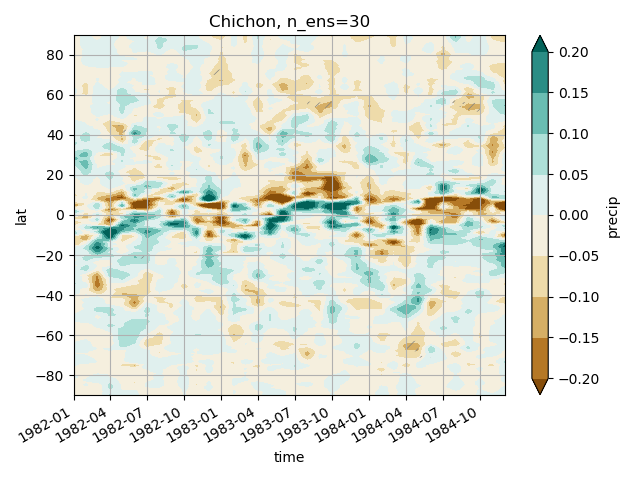

In [29]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0, cmap='BrBG')
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

### Zonal mean:  Land only

In [18]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.where(land_mask>.5).mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


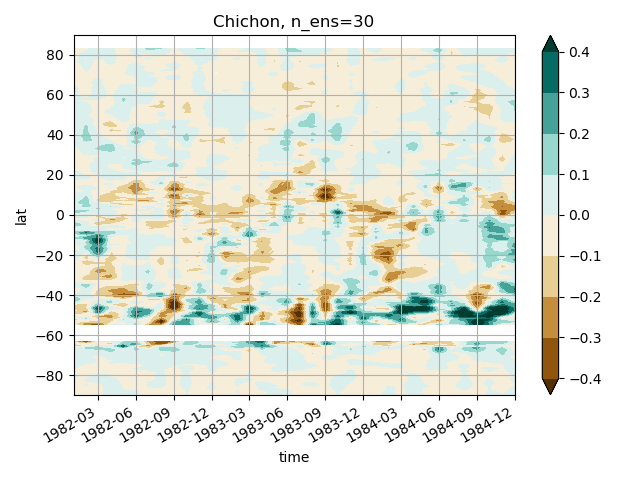

In [19]:
da.plot.contourf(x='time', y='lat', levels=np.arange(-.4,.41,.1), robust=True, center=0, cmap='BrBG')
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

### Zonal mean:  Land only, 20W-55E

In [5]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.where(land_mask>.5).where((daa.lon>=340)|(daa.lon<=55)).mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


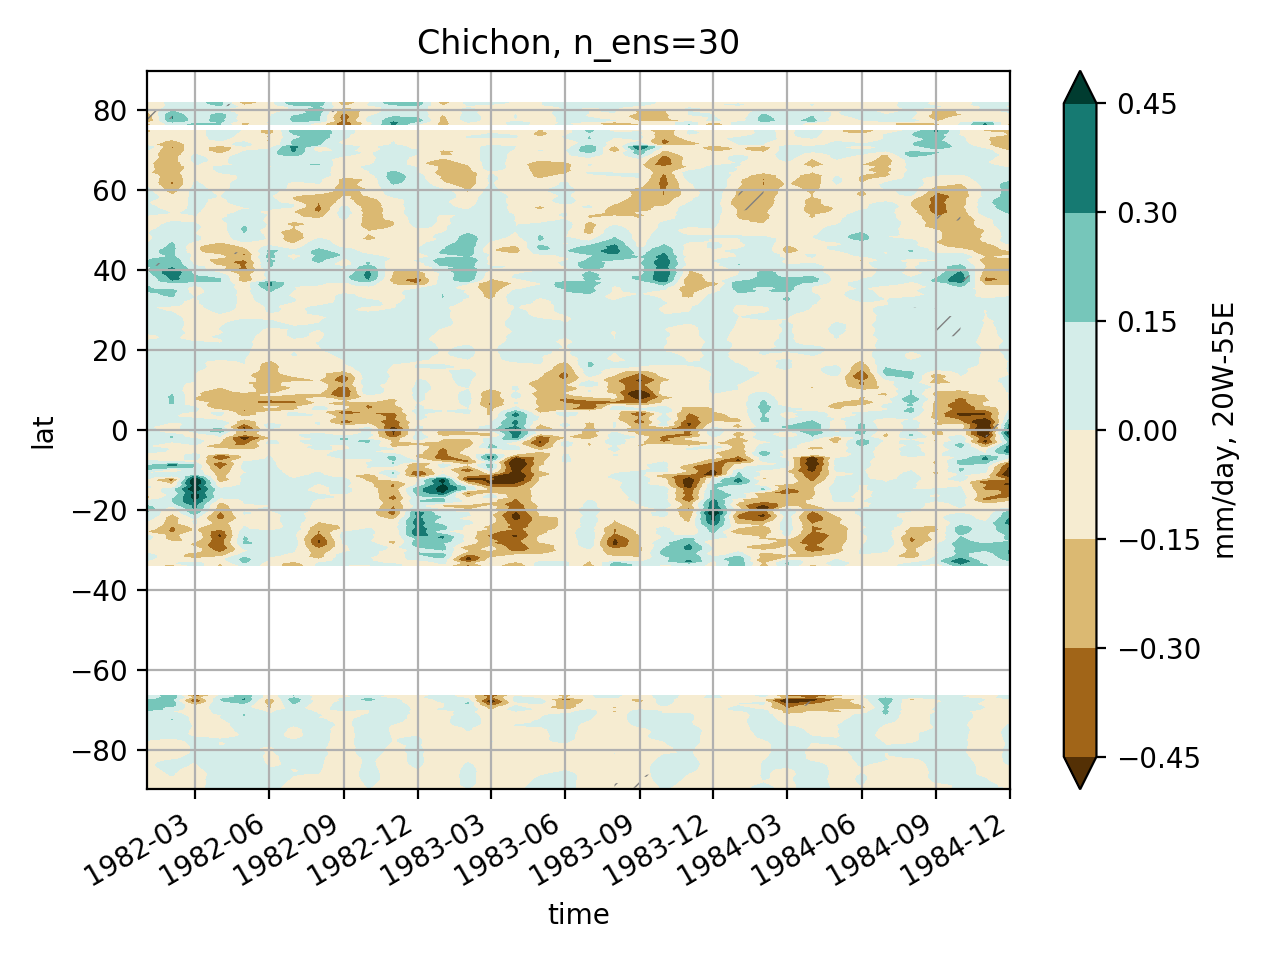

In [7]:
da.rename('mm/day, 20W-55E').plot.contourf(x='time', y='lat', levels=None, robust=True, center=0, cmap='BrBG')
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

### Zonal mean: Land only, Nino ens

In [10]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.where(land_mask>.5).mean('lon') # zonal mean
daa = daa.sel(en=nino_ens)
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


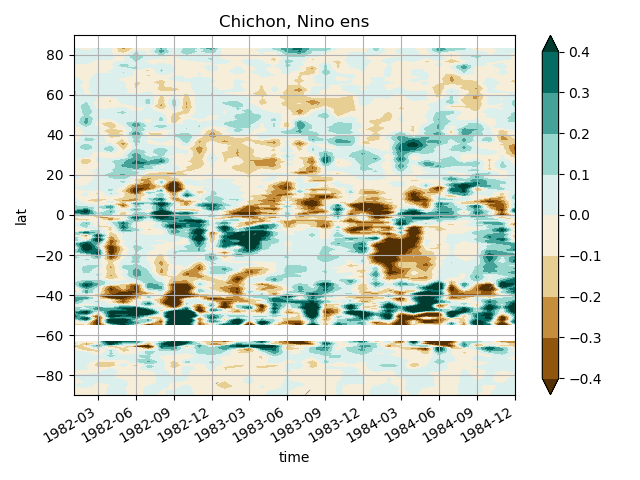

In [12]:
da.plot.contourf(x='time', y='lat', levels=np.arange(-.4,.41,.1), robust=True, center=0, cmap='BrBG')
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, Nino ens')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

### Zonal mean: Land only, Nina ens

In [13]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.where(land_mask>.5).mean('lon') # zonal mean
daa = daa.sel(en=nina_ens)
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


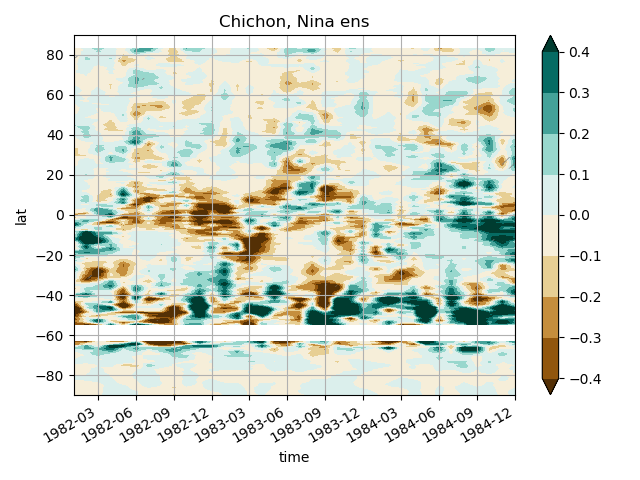

In [14]:
da.plot.contourf(x='time', y='lat', levels=np.arange(-.4,.41,.1), robust=True, center=0, cmap='BrBG')
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, Nina ens')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

### Zonal mean: Land only, Neut ens

In [15]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.where(land_mask>.5).mean('lon') # zonal mean
daa = daa.sel(en=neut_ens)
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


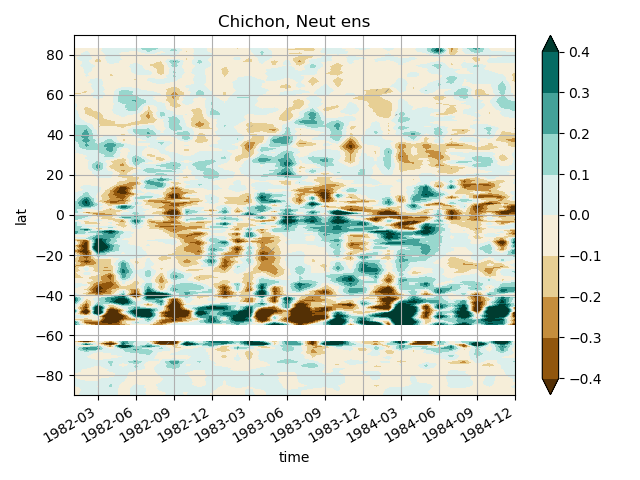

In [16]:
da.plot.contourf(x='time', y='lat', levels=np.arange(-.4,.41,.1), robust=True, center=0, cmap='BrBG')
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, Neut ens')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

### ITCZ

<IPython.core.display.Javascript object>


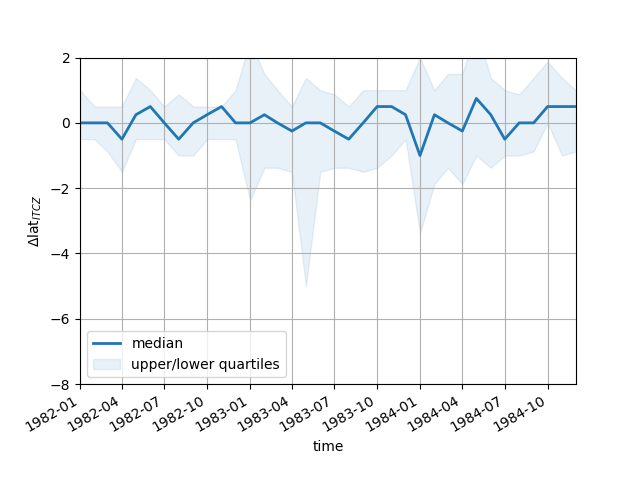

(-8, 2)

In [40]:
da_lonmean_ctl = da_ctl.mean('lon')
lat_itcz_ctl = da_lonmean_ctl.lat[da_lonmean_ctl.argmax('lat')]

da_lonmean_volc = da_volcano.mean('lon')
lat_itcz_volc = da_lonmean_volc.lat[da_lonmean_volc.argmax('lat')]

dlat_itcz = lat_itcz_volc - lat_itcz_ctl

plt.fill_between(dlat_itcz.time.to_index().to_pydatetime(),
    dlat_itcz.quantile(0.25, dim='en'),
    dlat_itcz.quantile(0.75, dim='en'),
    color='C0', alpha=0.1, label='upper/lower quartiles')
dlat_itcz.median('en').plot(color='C0', label='median')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(dlat_itcz.isel(time=[0,-1]).time.to_index())
plt.ylabel('$\Delta$lat$_{ITCZ}$')
plt.legend(frameon=True, loc='lower left')
plt.ylim(-8,2)

<IPython.core.display.Javascript object>


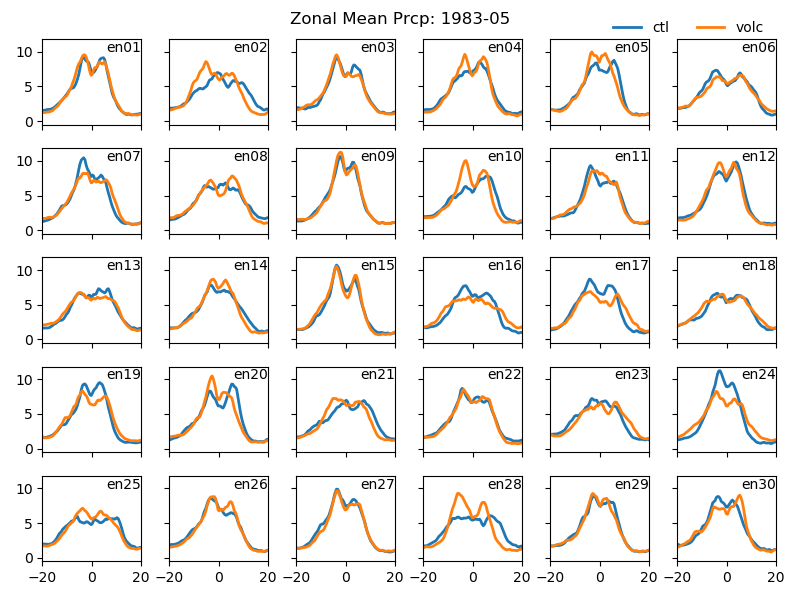

In [42]:
year_month = '1983-05'
fig, axes = plt.subplots(5,6, figsize=(8,6), sharex=True, sharey=True)
for i,ax in enumerate(axes.flat, start=1):
    plt.sca(ax)
    da_lonmean_ctl.sel(time=year_month).sel(en=i).plot(label='ctl', ax=ax)
    da_lonmean_volc.sel(time=year_month).sel(en=i).plot(label='volc', ax=ax)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(-20,20)
    if i == 6:
        plt.legend(bbox_to_anchor=(1,0.9), ncol=2, loc='lower right')
    plt.text(1,.98,f'en{i:02d}', transform=ax.transAxes, ha='right', va='top')
    
plt.suptitle(f'Zonal Mean Prcp: {year_month}')
plt.tight_layout(w_pad=-4)

## Sea level pressure ``slp``

In [30]:
data_name = 'slp'

ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.slp.ctl.nc
Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.slp.nc


In [31]:
# seasonal mean
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

<IPython.core.display.Javascript object>


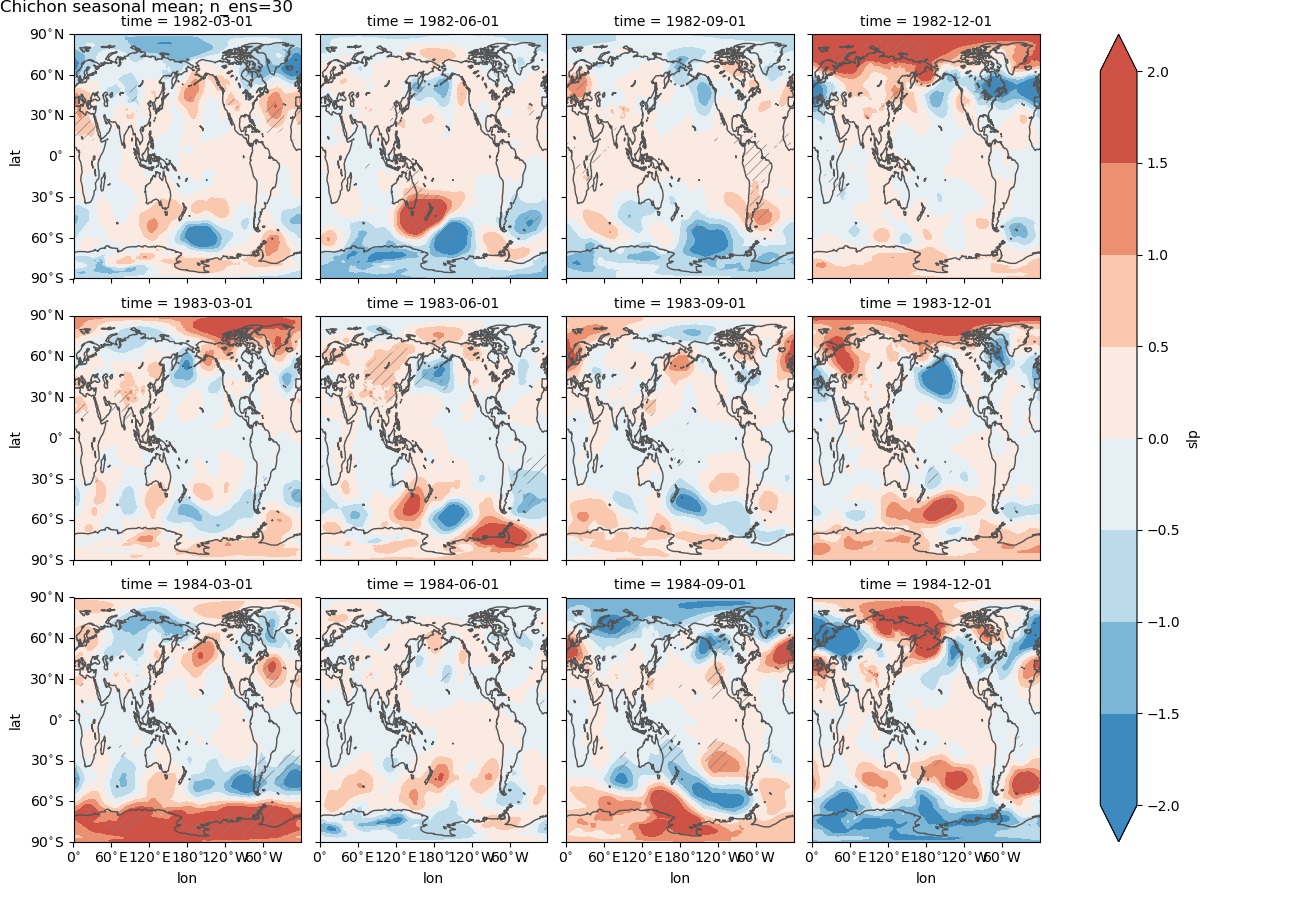

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [32]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name} seasonal mean; n_ens={len(ens)}', x=0, y=1, ha='left')

<IPython.core.display.Javascript object>


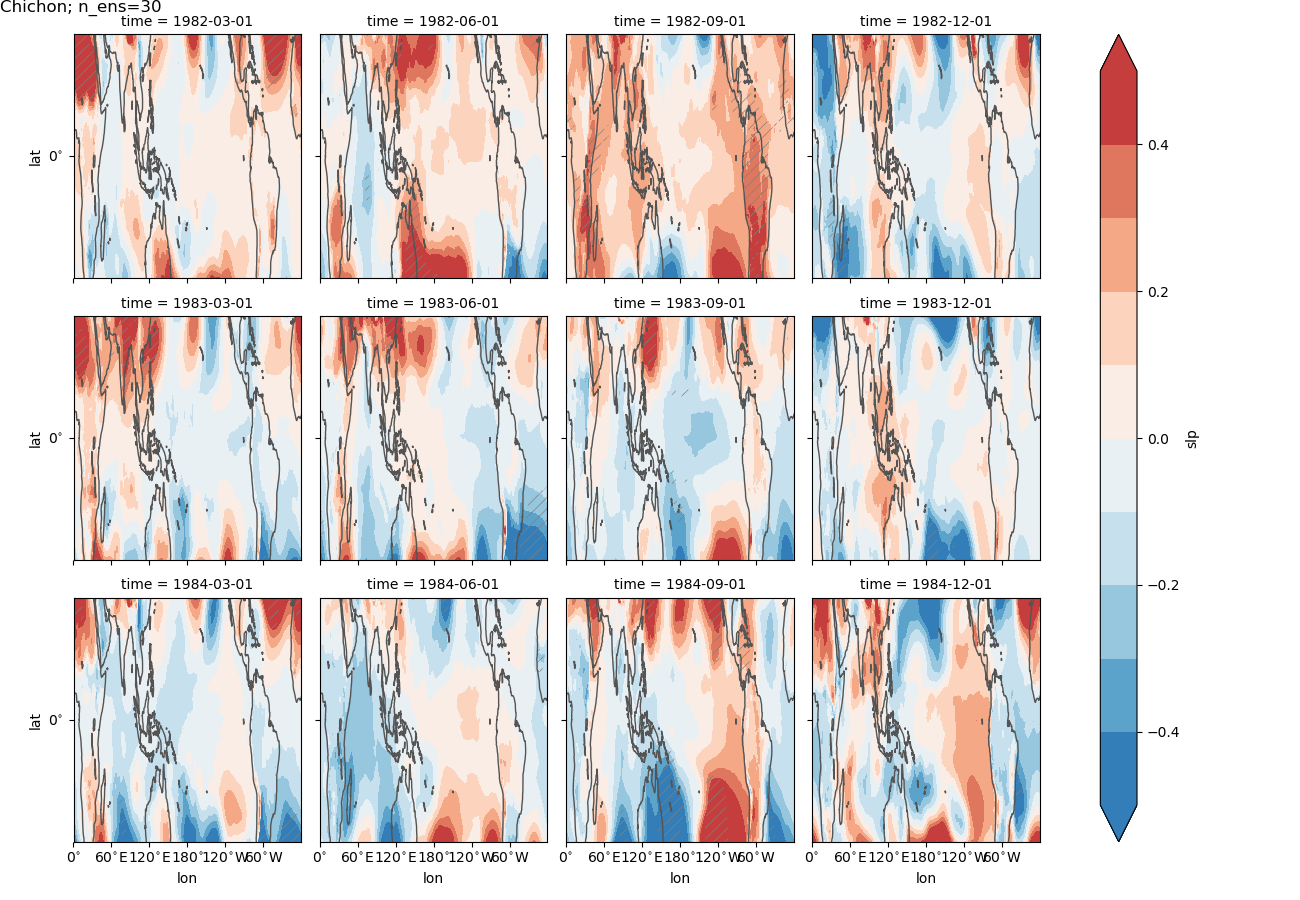

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [33]:
# tropics only
latrange = slice(-30,30)
f = da.sel(lat=latrange).plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).sel(lat=latrange).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

## Zonal-mean temperature ``temp``

In [34]:
data_name = 'temp'

ncfile = f'cache/{nbname}.{data_name}.lonmean.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).mean('lon').load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.lonmean.nc'
try:
    da_volcano = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).mean('lon').load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.temp.lonmean.ctl.nc
Data loaded from cache/volcano_impact_on_climate_chichon.ipynb.temp.lonmean.nc


In [35]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

<IPython.core.display.Javascript object>


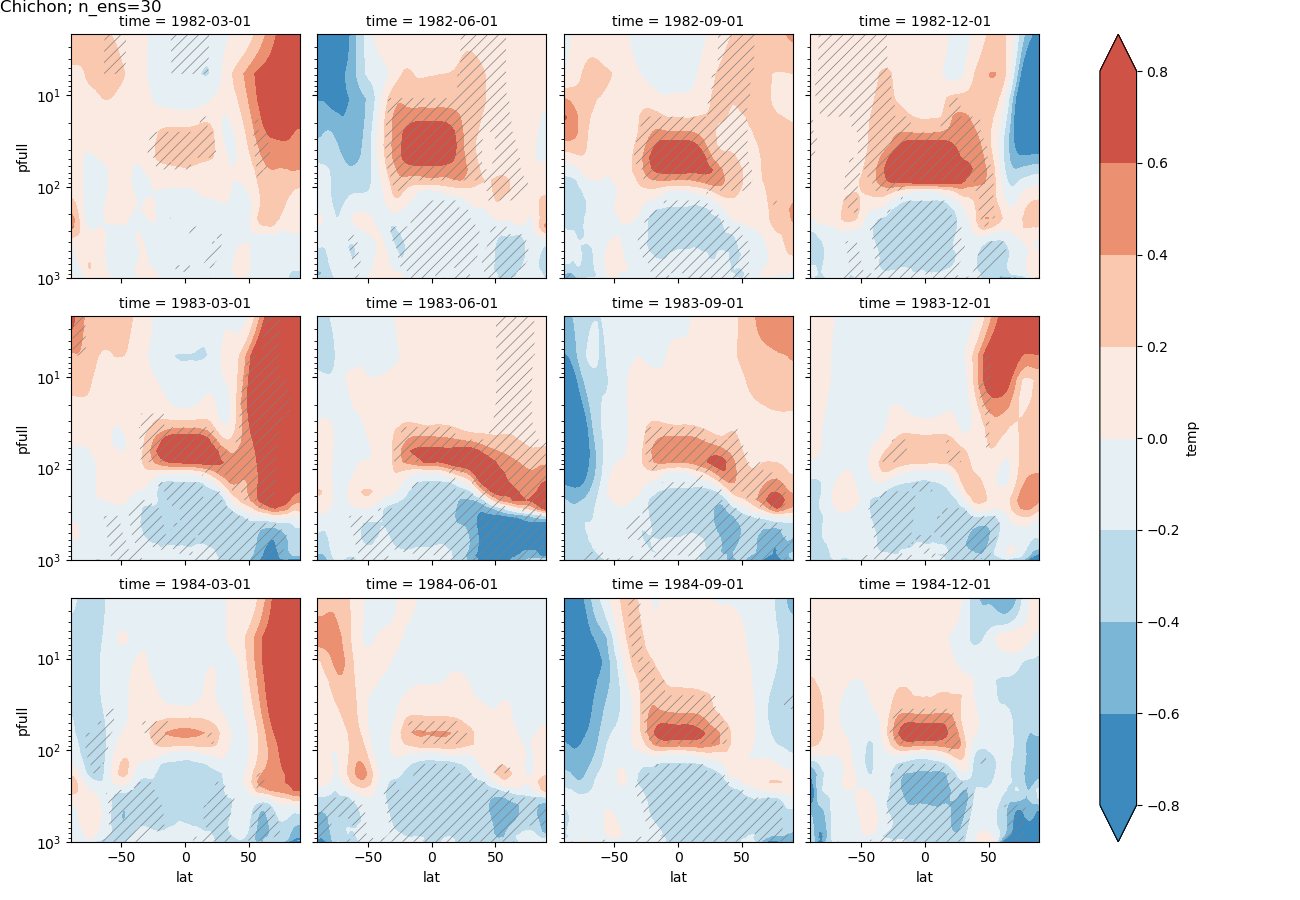

In [36]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both', yincrease=False)
for ii, ax in enumerate(f.axes.flat):
#     mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False, yincrease=False)
    ax.set_yscale('log')
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')